In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9259259259259259, Loss: 0.40620093875461155
Checkpoint 200, Accuracy: 0.9074074074074074, Loss: 0.36871436790183737
Checkpoint 300, Accuracy: 0.9135802469135802, Loss: 0.36795344176115813
Checkpoint 400, Accuracy: 0.9074074074074074, Loss: 0.3717270250673647
Checkpoint 500, Accuracy: 0.9259259259259259, Loss: 0.3580411981653284


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8281156  0.04243315 0.1294513 ]
[0. 1. 0.] <-> [0.31429675 0.67486346 0.01083984]
[1. 0. 0.] <-> [0.7646518  0.16411988 0.07122832]
[1. 0. 0.] <-> [0.692341   0.03917788 0.26848108]
[1. 0. 0.] <-> [0.781575   0.15496558 0.06345946]
[1. 0. 0.] <-> [0.7935092  0.13600013 0.07049064]
[1. 0. 0.] <-> [0.83991396 0.08295555 0.07713048]
[1. 0. 0.] <-> [0.8334194  0.0621284  0.10445227]
[1. 0. 0.] <-> [0.817748   0.11433189 0.0679201 ]
[0. 1. 0.] <-> [0.23647377 0.75760496 0.00592135]
[1. 0. 0.] <-> [0.8465945  0.05572944 0.09767613]
[1. 0. 0.] <-> [0.8251062  0.09875426 0.07613956]
[1. 0. 0.] <-> [0.84888417 0.07491053 0.07620531]
[0. 1. 0.] <-> [0.34127203 0.6468935  0.01183446]
[1. 0. 0.] <-> [0.82270026 0.06055053 0.11674929]
[0. 0. 1.] <-> [0.38574472 0.00947356 0.60478175]
[1. 0. 0.] <-> [0.80205995 0.12319206 0.07474791]
[1. 0. 0.] <-> [0.82391334 0.11678156 0.0593051 ]
[1. 0. 0.] <-> [0.8025596  0.11508757 0.08235285]
[0. 1. 0.] <-> [0.5410139  0.43740007 0.02158601]


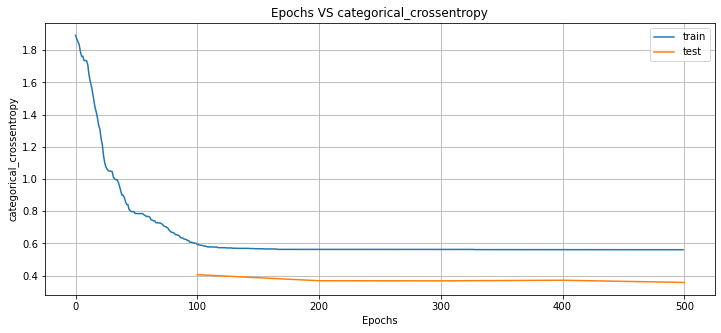

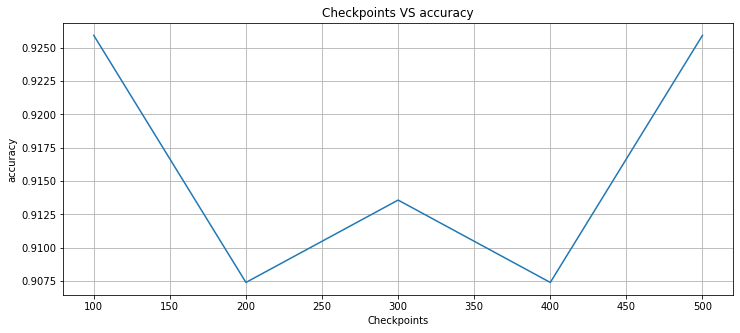

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9259259259259259, 'mean_square_error': 0.2102991305928104, 'categorical_crossentropy': 0.40620093875461155, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 12, 'tn_hit': 18, 'fn_hit': 0}, 1: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 7}, 2: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.9074074074074074, 'mean_square_error': 0.19483283736539128, 'categorical_crossentropy': 0.36871436790183737, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 15, 'tn_hit': 15, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 6}, 2: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 9}}, 'checkpoint': 200} 


{'accuracy': 0.9135802469135802, 'mean_square_error': 0.19124327399276567, 'categorical_crossentropy': 0.36795344176115813, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 14, 'tn_hit': 16, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 6}, 2: {'tp_hit': 6, 'fp_hit': 0, 'tn_hit': 94, '

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.43346828 -1.0357658  -0.74387693 -0.11652422  0.10910027]
 bias: 0.42044001817703247

Neuron 1: weights:
[ 0.44415766 -0.9128129  -0.72230893 -0.02481625  0.27973425]
 bias: 0.32470521330833435

Neuron 2: weights:
[-0.32722083  0.6322744  -0.19076806 -0.9123521  -0.9617079 ]
 bias: 0.8350909352302551

Neuron 3: weights:
[-0.36772817  0.72581154  0.5167969  -0.22045264 -0.3179122 ]
 bias: 0.005735693499445915

$
Layer 2
Neuron 0: weights:
[ 0.79916626  0.58426464  1.2112148  -0.23861454]
 bias: -0.24635367095470428

Neuron 1: weights:
[-1.6065335 -1.3970106  0.6073589  1.1381334]
 bias: 0.15649448335170746

Neuron 2: weights:
[ 0.8357433  1.0370077 -1.9909391 -1.1003882]
 bias: 0.078292615711689

$

